In [1]:
# Imports using Sklearn make shortcut functions
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Imports
import os
from google.cloud import bigquery

In [2]:
# Environment variables
gcp_project_id = os.environ['GCP_PROJECT']
gcp_service_account_key = os.environ['GCP_SERVICE_ACCOUNT_KEY']
bq_source_dataset = os.environ['BQ_SOURCE_DATASET']
bq_cleaned_dataset = os.environ['BQ_CLEANED_DATASET']

In [3]:
# Import data from BQ and set data to X
# Initialize a BigQuery client using the service account JSON file
bq_client = bigquery.Client(project=gcp_project_id).from_service_account_json(gcp_service_account_key)

# Setting the table we want from the source dataset
select_table = 'cleaned_full_polls_combined_national_results_2004_2019'

# SQL query for querying Big Query and fetching entire table
query = f"""
    SELECT *
    FROM `{gcp_project_id}.{bq_cleaned_dataset}.{select_table}`
"""

In [4]:
# Use BQ client to create DF from the selected table
data = bq_client.query(query).to_dataframe()

/Users/nieksonneveld/.pyenv/versions/3.10.6/envs/election_predictor/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [5]:
# Replace any found NaN values with 0
data.replace(np.nan, 0, inplace=True)

# Add a field 'poll length' that shows number of days the poll was held for
data['poll_length'] = pd.to_datetime(data.enddate) - pd.to_datetime(data.startdate)
data['poll_length'] = data['poll_length'].dt.days

# Divide forecasts by 100 to create values between 0-1
for column in ['BRX_FC', 'CON_FC', 'GRE_FC', 'LAB_FC', 'LIB_FC', 'NAT_FC', 'OTH_FC', 'PLC_FC', 'SNP_FC', 'UKI_FC']:
    data[column] = data[column] / 100

    # Divide actuals by 100 to create values between 0-1
for column in ['BRX_ACT', 'CON_ACT', 'GRE_ACT', 'LIB_ACT', 'LAB_ACT', 'NAT_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT', 'OTH_PERCENTAGE']:
    data[column] = data[column] / 100

data.sort_values('enddate', inplace=True)

data.reset_index(inplace=True)

In [6]:
# Load Trends csvs from raw_data folder
trends1 = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/LAB_CON_LIB_GRE_BRX_Trends_2004_now.csv')
trends2 = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/LAB_PLC_SNP_UKI_NAT_Trends_2004_now.csv')

In [7]:
# Drop duplicate Labour column
trends2.drop(columns='Labour Party: (United Kingdom)',inplace=True)

In [8]:
# Join two trends datasets on 'Month'
trends_merged = pd.merge(trends1,trends2,how='left',on='Month')

In [9]:
trends_merged['Month'] = pd.to_datetime(trends_merged['Month'])

In [10]:
# Replace <1 values with 0.5 value
trends_merged.replace('<1', 0.5,inplace=True)

In [11]:
# Converting objects (pd.Series) to int dtypes
trends_merged = trends_merged.astype({'Green Party: (United Kingdom)':'int','Reform UK: (United Kingdom)':'int',\
    'Plaid Cymru: (United Kingdom)':'int','Scottish National Party: (United Kingdom)':'int',\
        'UK Independence Party: (United Kingdom)':'int','British National Party: (United Kingdom)':'int'})

In [12]:
# Rename columns to align them more easily with _FC and _ACT columns
trends_merged.rename(columns={'Labour Party: (United Kingdom)': 'LAB_trends',
        'Conservative Party: (United Kingdom)': 'CON_trends',
        'Liberal Democrats: (United Kingdom)': 'LIB_trends',
        'Green Party: (United Kingdom)': 'GRE_trends',
        'Reform UK: (United Kingdom)': 'BRX_trends',
        'Plaid Cymru: (United Kingdom)': 'PLC_trends',
        'Scottish National Party: (United Kingdom)': 'SNP_trends',
        'UK Independence Party: (United Kingdom)': 'UKI_trends',
        'British National Party: (United Kingdom)': 'NAT_trends'}
        ,inplace=True)

In [13]:
# Loading ONS csv files
ons_gdp = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/ons_gdp_2004_2024.csv')
ons_inf = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/ons_inflation_2004_2024.csv')
ons_emp = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/ons_unemployment_2004_2024.csv')

In [14]:
# Replacing spaces with - for GDP df
ons_gdp.Quarter = ons_gdp.Quarter.str.replace(' ', '-')

# Turning quarters into months for GDP df
ons_gdp.Quarter = pd.PeriodIndex(ons_gdp.Quarter, freq='Q').to_timestamp()

# Fill missing months and impute with quarterly values per month for GDP df
ons_gdp = ons_gdp.set_index('Quarter').resample('MS').ffill()
ons_gdp.index.names = ['Month']

In [15]:
# Convert months into pd.DateTime and set as index
ons_inf.Month = pd.to_datetime(ons_inf.Month)
ons_inf = ons_inf.set_index('Month')

ons_emp.Month = pd.to_datetime(ons_emp.Month)
ons_emp = ons_emp.set_index('Month')

/var/folders/kb/jn3km5pj6lnd7dfkgljcjy300000gn/T/ipykernel_6076/3454880804.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ons_inf.Month = pd.to_datetime(ons_inf.Month)
/var/folders/kb/jn3km5pj6lnd7dfkgljcjy300000gn/T/ipykernel_6076/3454880804.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ons_emp.Month = pd.to_datetime(ons_emp.Month)


In [16]:
# Merging GDP, Inflation and Unemployment dfs into ons_merged
ons_merged = pd.merge(ons_gdp,pd.merge(ons_inf,ons_emp,how='left',on='Month'),how='outer',on='Month')

# Filling NaNs with previous value of column
ons_merged = ons_merged.ffill()

In [21]:
ons_merged.head()

,GDP,Inflation,Unemployment
Month,,,
2004-01-01,322790.0,1.5,4.8
2004-02-01,322790.0,1.4,4.8
2004-03-01,322790.0,1.2,4.8
2004-04-01,329664.0,1.1,4.8
2004-05-01,329664.0,1.4,4.8


In [22]:
# Create poll enddate field with YYYY-MM format, so we can join with Trends data
data['enddate_year_month'] = pd.to_datetime(data['enddate']).dt.to_period('M')

In [23]:
# Convert Period datatype to str and then to datetime64
data.enddate_year_month = pd.to_datetime(data.enddate_year_month.astype('str'))

In [24]:
# Merge data with trends data, to get a df with polls, election results and trends
data_trends = pd.merge(data,trends_merged,how='left',left_on='enddate_year_month',right_on='Month')

In [25]:
# Merge data with ONS data, to get a df with polls, election results, trends and ONS data
data_trends_ons = pd.merge(data_trends,ons_merged,how='left',left_on='enddate_year_month',right_on='Month')

In [26]:
# Scale trends columns by diving by 100
for column in ['LAB_trends', 'CON_trends', 'LIB_trends',
       'GRE_trends', 'BRX_trends', 'PLC_trends', 'SNP_trends', 'UKI_trends',
       'NAT_trends']:
    data_trends_ons[column] = data_trends_ons[column] / 100

In [27]:
# Drop columns we don't need
data_trends_ons = data_trends_ons.drop(columns=['startdate', 'enddate', 'pollster'])

In [32]:
data_trends_ons.columns

Index(['index', 'samplesize', 'rating', 'next_elec_date', 'days_to_elec',
       'BRX_FC', 'CON_FC', 'GRE_FC', 'LAB_FC', 'LIB_FC', 'NAT_FC', 'OTH_FC',
       'PLC_FC', 'SNP_FC', 'UKI_FC', 'NAT_ACT', 'BRX_ACT', 'CON_ACT',
       'GRE_ACT', 'LIB_ACT', 'LAB_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT',
       'OTH_PERCENTAGE', 'poll_length', 'enddate_year_month', 'Month',
       'LAB_trends', 'CON_trends', 'LIB_trends', 'GRE_trends', 'BRX_trends',
       'PLC_trends', 'SNP_trends', 'UKI_trends', 'NAT_trends', 'GDP',
       'Inflation', 'Unemployment'],
      dtype='object')

In [28]:
from datetime import datetime
# Split data up to 2017 election (TRAIN) and all data related to 2019 election (TEST)
data_trends_ons['next_elec_date'] = data_trends_ons['next_elec_date'].astype("datetime64[ns]")
data_train = data_trends_ons[data_trends_ons['next_elec_date'] < datetime.strptime('2019-12-12', '%Y-%m-%d')]
data_test = data_trends_ons[data_trends_ons['next_elec_date'] == datetime.strptime('2019-12-12', '%Y-%m-%d')]

In [29]:
# Handle numerical transformer
num_columns_selector = ['samplesize', 'days_to_elec', 'poll_length','GDP','Inflation','Unemployment']
num_transformer = MinMaxScaler()

In [30]:
# Handle categorical transformer
cat_columns_selector = ['rating']
cat_transformer = make_pipeline(OrdinalEncoder(categories = [['F','D-','D','D+','C-','B','B+','A-']]),MinMaxScaler())

In [31]:
# Build the preprocessing pipeline
preproc_pipeline = make_column_transformer(
    (num_transformer, num_columns_selector),
    (cat_transformer, cat_columns_selector),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [33]:
# Fit transform preprocessing pipeline to data_train
data_train_processed = preproc_pipeline.fit_transform(data_train)

# Transform preprocessing pipeline to data_test
data_test_processed = preproc_pipeline.transform(data_test)

In [34]:
# Check feature names make sense for data_train
data_train_processed = pd.DataFrame(
    data_train_processed, columns=preproc_pipeline.get_feature_names_out()
)

# Check feature names make sense for data_test
data_test_processed = pd.DataFrame(
    data_test_processed, columns=preproc_pipeline.get_feature_names_out()
)

In [35]:
data_train_processed.columns

Index(['samplesize', 'days_to_elec', 'poll_length', 'GDP', 'Inflation',
       'Unemployment', 'rating', 'index', 'next_elec_date', 'BRX_FC', 'CON_FC',
       'GRE_FC', 'LAB_FC', 'LIB_FC', 'NAT_FC', 'OTH_FC', 'PLC_FC', 'SNP_FC',
       'UKI_FC', 'NAT_ACT', 'BRX_ACT', 'CON_ACT', 'GRE_ACT', 'LIB_ACT',
       'LAB_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT', 'OTH_PERCENTAGE',
       'enddate_year_month', 'Month', 'LAB_trends', 'CON_trends', 'LIB_trends',
       'GRE_trends', 'BRX_trends', 'PLC_trends', 'SNP_trends', 'UKI_trends',
       'NAT_trends'],
      dtype='object')

In [36]:
# Define our X by dropping irrelevant and y columns

X_train = data_train_processed.drop(columns=['index','next_elec_date','NAT_ACT', 'BRX_ACT', 'CON_ACT',
       'GRE_ACT', 'LIB_ACT', 'LAB_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT',
       'OTH_PERCENTAGE','enddate_year_month','Month'])

X_test = data_test_processed.drop(columns=['index','next_elec_date','NAT_ACT', 'BRX_ACT', 'CON_ACT',
       'GRE_ACT', 'LIB_ACT', 'LAB_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT',
       'OTH_PERCENTAGE','enddate_year_month','Month'])

In [37]:
# Build our target matrix, retaining each party share vote columns only
y_train = data_train_processed[['LAB_ACT', 'CON_ACT', 'LIB_ACT', 'GRE_ACT', 'BRX_ACT',
                    'NAT_ACT', 'SNP_ACT', 'UKI_ACT', 'PLC_ACT', 'OTH_PERCENTAGE']]

# Build our target matrix, retaining each party share vote columns only
y_test = data_test_processed[['LAB_ACT', 'CON_ACT', 'LIB_ACT', 'GRE_ACT', 'BRX_ACT',
                    'NAT_ACT', 'SNP_ACT', 'UKI_ACT', 'PLC_ACT', 'OTH_PERCENTAGE']]

In [38]:
#TODO – refactor the below into a function > model instantiation, fitting, scoring, etc.
# Handle target extraction for test and train sets respectively
#TODO Kwarg > defaults to either cross val or prediction
y_train_LAB = y_train['LAB_ACT']
y_train_CON = y_train['CON_ACT']
y_train_LIB = y_train['LIB_ACT']
y_train_GRE = y_train['GRE_ACT']
y_train_BRX = y_train['BRX_ACT']
y_train_NAT = y_train['NAT_ACT']
y_train_SNP = y_train['SNP_ACT']
y_train_UKI = y_train['UKI_ACT']
y_train_PLC = y_train['PLC_ACT']
y_train_OTH = y_train['OTH_PERCENTAGE']

y_test_LAB = y_test['LAB_ACT']
y_test_CON = y_test['CON_ACT']
y_test_LIB = y_test['LIB_ACT']
y_test_GRE = y_test['GRE_ACT']
y_test_BRX = y_test['BRX_ACT']
y_test_NAT = y_test['NAT_ACT']
y_test_SNP = y_test['SNP_ACT']
y_test_UKI = y_test['UKI_ACT']
y_test_PLC = y_test['PLC_ACT']
y_test_OTH = y_test['OTH_PERCENTAGE']

In [39]:
# Instantiate the model for each party
model_LAB = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)
model_CON = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)
model_LIB = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)
model_GRE = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)
model_BRX = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)
model_NAT = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)
model_SNP = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)
model_UKI = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)
model_PLC = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)
model_OTH = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     enable_categorical=True)

In [40]:
# Handle model training
X_train_matrix = np.array(X_train)

model_LAB.fit(X_train_matrix, y_train_LAB)
model_CON.fit(X_train_matrix, y_train_CON)
model_LIB.fit(X_train_matrix, y_train_LIB)
model_GRE.fit(X_train_matrix, y_train_GRE)
model_BRX.fit(X_train_matrix, y_train_BRX)
model_NAT.fit(X_train_matrix, y_train_NAT)
model_SNP.fit(X_train_matrix, y_train_SNP)
model_UKI.fit(X_train_matrix, y_train_UKI)
model_PLC.fit(X_train_matrix, y_train_PLC)
model_OTH.fit(X_train_matrix, y_train_OTH)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)

In [41]:
# Evaluate model performance with cross validation
X_test_matrix = np.array(X_test)

y_pred_LAB = model_LAB.predict(X_test_matrix)
y_pred_CON = model_CON.predict(X_test_matrix)
y_pred_LIB = model_LIB.predict(X_test_matrix)
y_pred_GRE = model_GRE.predict(X_test_matrix)
y_pred_BRX = model_BRX.predict(X_test_matrix)
y_pred_NAT = model_NAT.predict(X_test_matrix)
y_pred_SNP = model_SNP.predict(X_test_matrix)
y_pred_UKI = model_UKI.predict(X_test_matrix)
y_pred_PLC = model_PLC.predict(X_test_matrix)
y_pred_OTH = model_OTH.predict(X_test_matrix)

In [42]:
print(f"2019 prediction for LAB: {y_pred_LAB.mean()}")
print(f"2019 prediction for CON: {y_pred_CON.mean()}")
print(f"2019 prediction for LIB: {y_pred_LIB.mean()}")
print(f"2019 prediction for GRE: {y_pred_GRE.mean()}")
print(f"2019 prediction for BRX: {y_pred_BRX.mean()}")
print(f"2019 prediction for NAT: {y_pred_NAT.mean()}")
print(f"2019 prediction for SNP: {y_pred_SNP.mean()}")
print(f"2019 prediction for UKI: {y_pred_UKI.mean()}")
print(f"2019 prediction for PLC: {y_pred_PLC.mean()}")
print(f"2019 prediction for OTH: {y_pred_OTH.mean()}")

2019 prediction for LAB: 0.403704971075058
2019 prediction for CON: 0.4251406192779541
2019 prediction for LIB: 0.0735817551612854
2019 prediction for GRE: 0.015289939939975739
2019 prediction for BRX: 0.0
2019 prediction for NAT: 0.00013536341430153698
2019 prediction for SNP: 0.029834257438778877
2019 prediction for UKI: 0.015986083075404167
2019 prediction for PLC: 0.005168056581169367
2019 prediction for OTH: 0.03303728252649307


In [43]:
print(f"2019 prediction for LAB: {y_pred_LAB[-25:-1].mean()}")
print(f"2019 prediction for CON: {y_pred_CON[-25:-1].mean()}")
print(f"2019 prediction for LIB: {y_pred_LIB[-25:-1].mean()}")
print(f"2019 prediction for GRE: {y_pred_GRE[-25:-1].mean()}")
print(f"2019 prediction for BRX: {y_pred_BRX[-25:-1].mean()}")
print(f"2019 prediction for NAT: {y_pred_NAT[-25:-1].mean()}")
print(f"2019 prediction for SNP: {y_pred_SNP[-25:-1].mean()}")
print(f"2019 prediction for UKI: {y_pred_UKI[-25:-1].mean()}")
print(f"2019 prediction for PLC: {y_pred_PLC[-25:-1].mean()}")
print(f"2019 prediction for OTH: {y_pred_OTH[-25:-1].mean()}")

2019 prediction for LAB: 0.40694716572761536
2019 prediction for CON: 0.42701029777526855
2019 prediction for LIB: 0.07440411299467087
2019 prediction for GRE: 0.015539799816906452
2019 prediction for BRX: 0.0
2019 prediction for NAT: 0.00018707440176513046
2019 prediction for SNP: 0.029766013845801353
2019 prediction for UKI: 0.01657942496240139
2019 prediction for PLC: 0.005174857098609209
2019 prediction for OTH: 0.03304747864603996


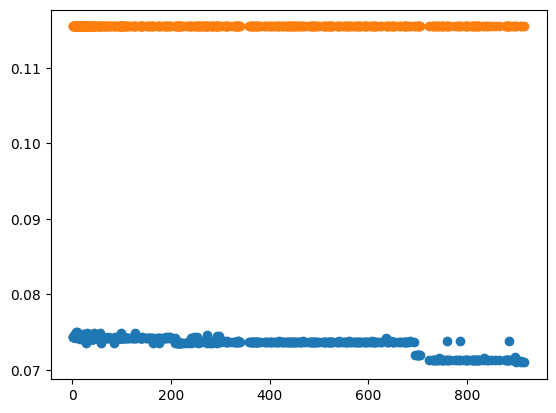

In [44]:
plt.scatter(y=y_pred_LIB,x=data_test['days_to_elec'])
plt.scatter(y=y_test_LIB,x=data_test['days_to_elec'])